In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [57]:
labels = {'Ab' : '$A_{B}$',
          'kb' : '$k_{B}$ [kV$\cdot$g/cm$^3$/MeV]',
          'eField' : '$\mathcal{E}$ [kV/cm]',
          'lifetime' : '$\\tau$ [$\mu s$]' ,
          'tran_diff' : '$D_{T}$ [$cm^2/\mu s$]',
          'long_diff' : '$D_{L}$ [$cm^2/\mu s$]'}

In [58]:
label_let = {'Ab' : 'a',
             'kb' : 'b',
             'eField' : 'c',
             'lifetime' : 'd' ,
             'tran_diff' : 'e',
             'long_diff' : 'f'}

In [59]:
from glob import glob

In [60]:
dir_name = "muon_1GeV/"

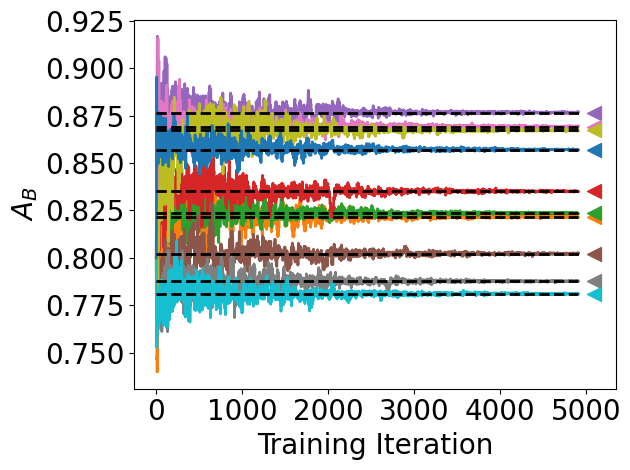

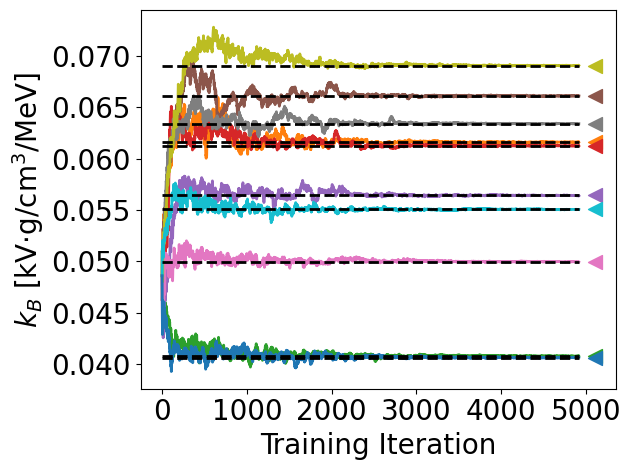

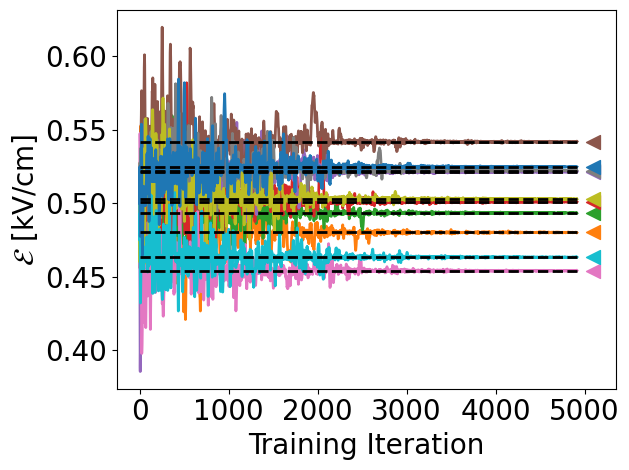

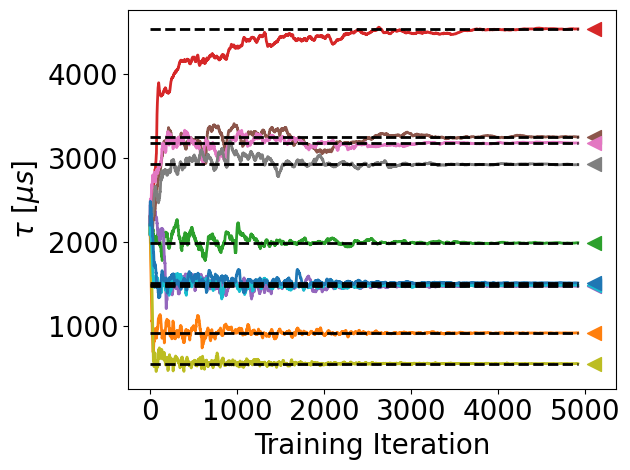

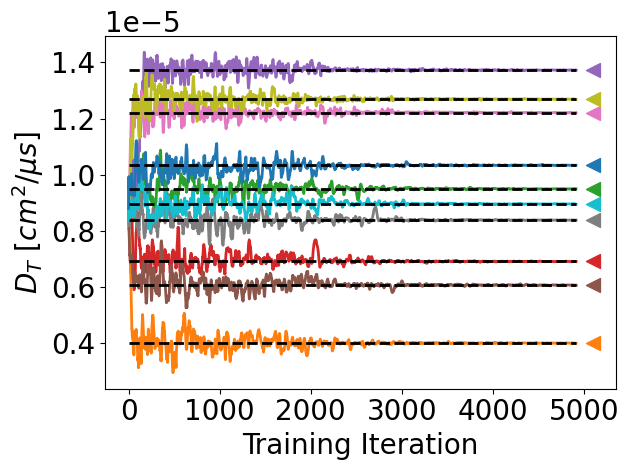

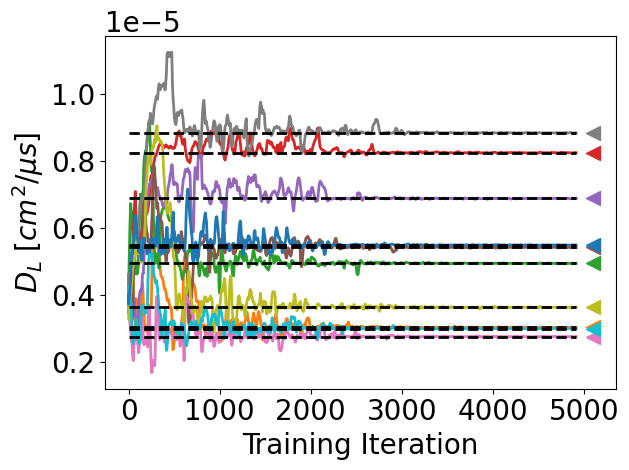

In [61]:
fig = 15
for param in labels.keys():
    for seed in range(1,11):
        history = pickle.load(open(glob(dir_name+f"*seed{seed}_*.pkl")[0], "rb"))

        plt.plot(np.asarray(history[f"{param}_iter"]), c=f'C{seed}', lw=2, zorder=0)
        plt.plot([0, len(history[f"{param}_iter"])], 
                 [history[f'{param}_target']]*2, c='k', ls='dashed', lw=2, zorder=1)
        plt.scatter(5100, history[f'{param}_target'], c=f'C{seed}', marker='<', s=100, zorder=2)

   # plt.xlim([0, 5190])
    plt.ylabel(labels[param], fontsize=20)
    plt.xlabel('Training Iteration', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().yaxis.get_offset_text().set_fontsize(20)
    plt.tight_layout()
    let = label_let[param]
    plt.savefig(f'figure{fig}{let}.pdf', bbox_inches='tight')
    plt.show()



In [62]:
dir_name = "mu_pi_p_mom_range/"

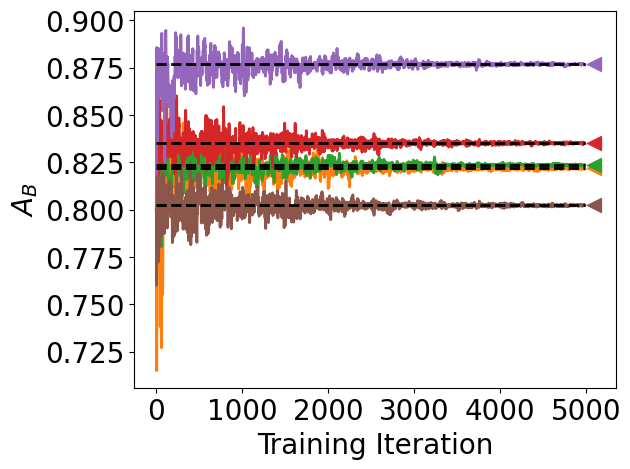

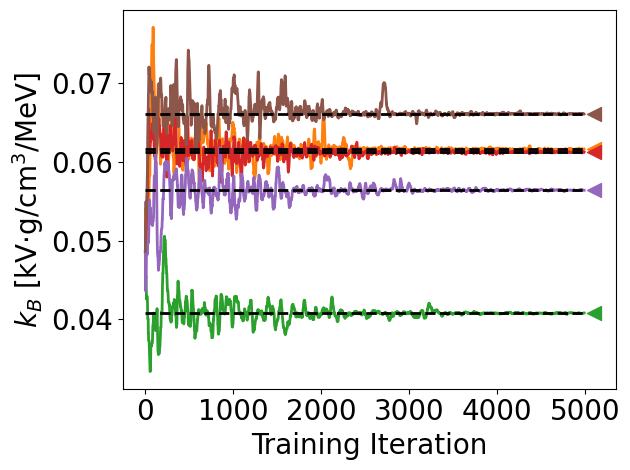

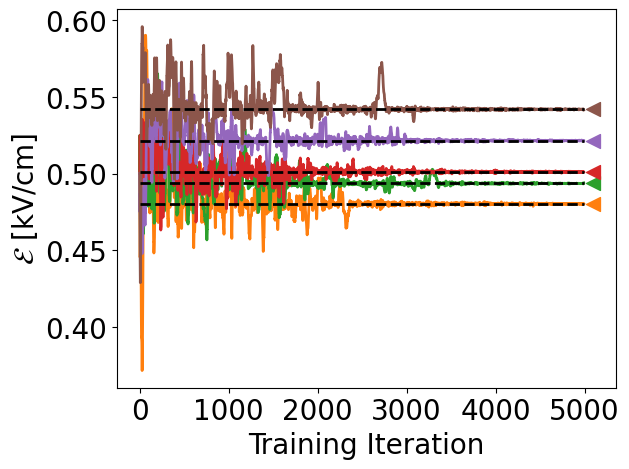

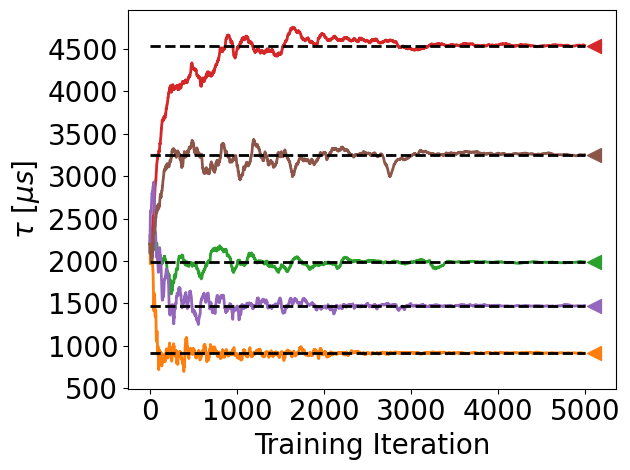

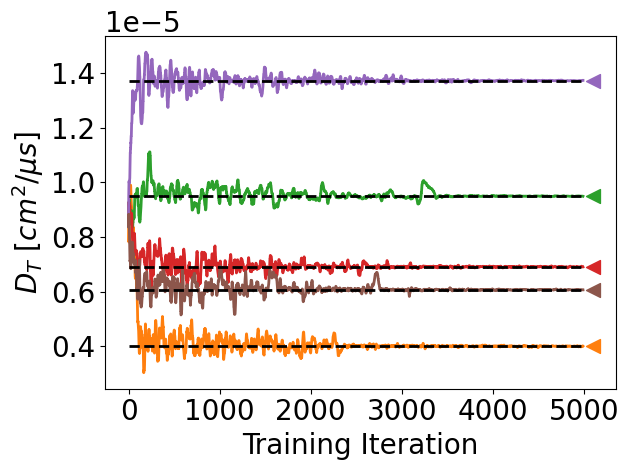

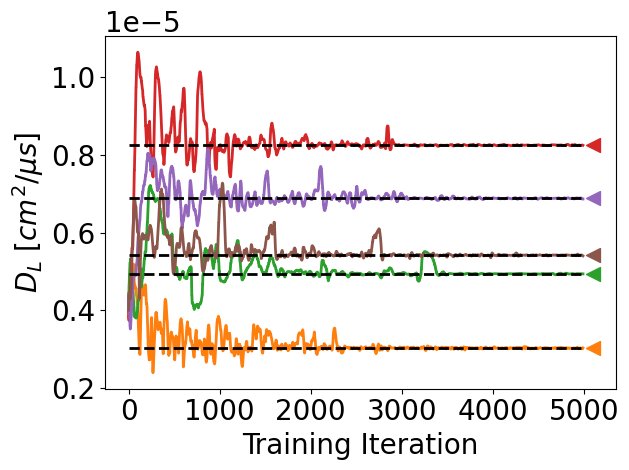

In [63]:
fig=17
for param in labels.keys():
    for seed in range(1,6):
        history = pickle.load(open(glob(dir_name+f"*seed{seed}_*.pkl")[0], "rb"))

        flat_history = []
        for item in history[f"{param}_iter"]:
            if type(item) == list:
                flat_history.append(item[0])
            else:
                flat_history.append(item)
                
        plt.plot(np.asarray(flat_history), c=f'C{seed}', lw=2, zorder=0)
        plt.plot([0, len(flat_history)], 
                 [history[f'{param}_target']]*2, c='k', ls='dashed', lw=2, zorder=1)
        plt.scatter(5100, history[f'{param}_target'], c=f'C{seed}', marker='<', s=100, zorder=2)

   # plt.xlim([0, 5190])
    plt.ylabel(labels[param], fontsize=20)
    plt.xlabel('Training Iteration', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().yaxis.get_offset_text().set_fontsize(20)
    plt.tight_layout()
    let = label_let[param]
    plt.savefig(f'figure{fig}{let}.pdf', bbox_inches='tight')
    plt.show()



In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch

In [4]:
y_cutoff=-10.
rate=100

In [5]:
y = torch.linspace(-2, 5, 1000)

all_smooth = []
rates = [5, 10, 20, 100]
for rate in rates:
    y_trunc = torch.maximum(y, y_cutoff*torch.ones(len(y)))
    smooth_vals = torch.sigmoid(rate*y_trunc)*torch.exp(-y_trunc)
    all_smooth.append(smooth_vals)
hard_vals = torch.exp(-torch.abs(y))*(y>0)

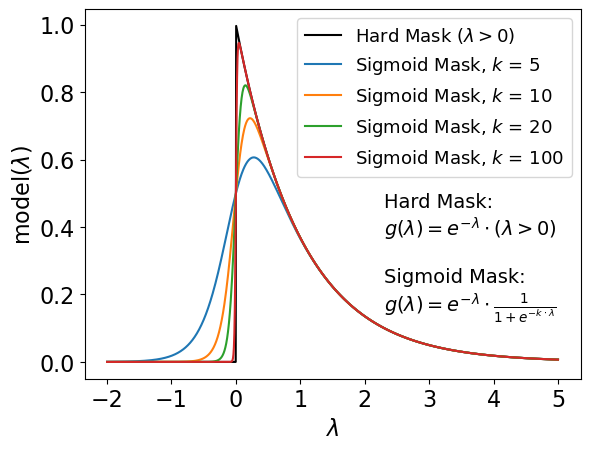

In [8]:
plt.plot(y, hard_vals, c='k', label='Hard Mask ($\\lambda > 0$)')
for i in range(len(all_smooth)):
    plt.plot(y, all_smooth[i], label=f'Sigmoid Mask, $k$ = {rates[i]}')
    
plt.text(2.3, 0.15,
         "Hard Mask: \n$g(\\lambda) = e^{-\\lambda} \cdot (\\lambda > 0)$ \n\nSigmoid Mask: \n$g(\\lambda) = e^{-\\lambda} \cdot \\frac{1}{1+e^{-k\cdot \\lambda}}$",
        fontsize=14)

plt.legend(fontsize=13)
plt.xlabel('$\\lambda$', fontsize=16)
plt.ylabel('model($\\lambda$)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure2.pdf', bbox_inches='tight')
plt.show()

In [1]:
%load_ext autoreload

%autoreload 2

In [150]:
from torch.utils.data import DataLoader

import sys
sys.path.insert(0, '../')
from optimize.dataio import TracksDataset
from optimize.utils import all_sim, get_id_map, embed_adc_list, calc_loss

from larndsim.sim_with_grad import sim_with_grad

import torch
import numpy as np

In [151]:
track_chunk = 1
pixel_chunk = 1
detector_props = "../larndsim/detector_properties/module0.yaml"
pixel_layouts = "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml"
input_file =  "/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim-output.h5"

dataset = TracksDataset(filename=input_file, ntrack=1)#, max_batch_len=100)
track_fields = dataset.get_track_fields()

In [152]:
selected_tracks_torch = dataset.tracks[:, 0:1]

In [153]:
def all_sim(sim, selected_tracks, fields, event_id_map, unique_eventIDs, return_unique_pix=False):
    selected_tracks_quench = sim.quench(selected_tracks, sim.birks, fields=fields)
    selected_tracks_drift = sim.drift(selected_tracks_quench, fields=fields)

    active_pixels_torch, neighboring_pixels_torch, n_pixels_list_ep = sim.get_pixels(selected_tracks_drift,
                                                                                     fields=fields)

    #track_starts_torch, max_length_torch = sim.time_intervals(event_id_map, 
    track_starts_torch, max_length_torch = sim.time_intervals(
                                                              selected_tracks_drift, 
                                                              fields=fields)
    
    signals_ep = sim.tracks_current(neighboring_pixels_torch, n_pixels_list_ep, selected_tracks_drift, 
                                          max_length_torch,
                                          fields=fields)

    unique_pix_torch = torch.empty((0, 2), device=neighboring_pixels_torch.device)
    pixels_signals_torch = torch.zeros((len(unique_pix_torch), len(sim.time_ticks)*3),
                                       device=unique_pix_torch.device, dtype=selected_tracks.dtype)

    shapes_torch = neighboring_pixels_torch.shape
    joined_torch = neighboring_pixels_torch.reshape(shapes_torch[0]*shapes_torch[1], 2)

    this_unique_pix_torch = torch.unique(joined_torch, dim=0)
    this_unique_pix_torch = this_unique_pix_torch[(this_unique_pix_torch[:,0] != -1) & (this_unique_pix_torch[:,1] != -1),:]
    unique_pix_torch = torch.cat((unique_pix_torch, this_unique_pix_torch),dim=0)

    this_pixels_signals_torch = torch.zeros((len(this_unique_pix_torch), len(sim.time_ticks)*3),
                                            device=unique_pix_torch.device)
    pixels_signals_torch = torch.cat((pixels_signals_torch, this_pixels_signals_torch), dim=0)

    pixel_index_map_torch = torch.full((selected_tracks.shape[0], neighboring_pixels_torch.shape[1]), -1,
                                       device=unique_pix_torch.device)
    compare_torch = (neighboring_pixels_torch[..., np.newaxis, :] == unique_pix_torch)

    indices_torch = torch.where(torch.logical_and(compare_torch[..., 0], compare_torch[...,1]))
    pixel_index_map_torch[indices_torch[0], indices_torch[1]] = indices_torch[2]
 
    pixels_signals_torch = sim.sum_pixel_signals(pixels_signals_torch,
                                                 signals_ep,
                                                track_starts_torch,
                                                pixel_index_map_torch)
   
    #time_ticks_torch = torch.linspace(0, len(unique_eventIDs)*sim.time_interval[1]*3, pixels_signals_torch.shape[1]+1)
    time_ticks_torch = torch.linspace(0, sim.time_interval[1]*3, pixels_signals_torch.shape[1]+1)

    integral_list_torch, adc_ticks_list_torch = sim.get_adc_values(pixels_signals_torch,
                                                                   time_ticks_torch,
                                                                   0)
    adc_list_torch = sim.digitize(integral_list_torch)

    if return_unique_pix:
        return adc_list_torch, unique_pix_torch, adc_ticks_list_torch, time_ticks_torch, pixels_signals_torch
    else:
        return adc_list_torch

In [154]:
def calc_forward(selected_tracks_torch, params, param_vals, device='cuda', noise=False, grad=False):
    sim_target = sim_with_grad(track_chunk=track_chunk, pixel_chunk=pixel_chunk, readout_noise=noise)
    sim_target.load_detector_properties(detector_props, pixel_layouts)
    sim_target.link_vdrift_eField = True
    
    for i in range(len(params)):
        if grad:
            val = torch.tensor(param_vals[i], requires_grad=True)
        else:
            val = param_vals[i]
        setattr(sim_target, params[i], val)

    selected_tracks_torch = torch.flatten(selected_tracks_torch, start_dim=0, end_dim=1)
    selected_tracks_torch = selected_tracks_torch[selected_tracks_torch[:, track_fields.index("dx")] > 0]

    event_id_map, unique_eventIDs = get_id_map(selected_tracks_torch, track_fields, device)
    selected_tracks_torch = selected_tracks_torch.to(device)

    target, pix_target, ticks_list_targ, time_ticks_torch, pixels_signals_torch = all_sim(sim_target, selected_tracks_torch, track_fields, 
                                                  event_id_map, unique_eventIDs, return_unique_pix=True)
    
    embed_target = embed_adc_list(sim_target, target, pix_target, ticks_list_targ)
    
    return embed_target, sim_target, time_ticks_torch, pixels_signals_torch

In [156]:
embed_target, sim_target, time_ticks_torch, pixels_signals_torch = calc_forward(selected_tracks_torch, [], [], device='cpu')

/sdf/group/magis/sgaz/sw/conda/envs/ml/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [157]:
import matplotlib.pyplot as plt

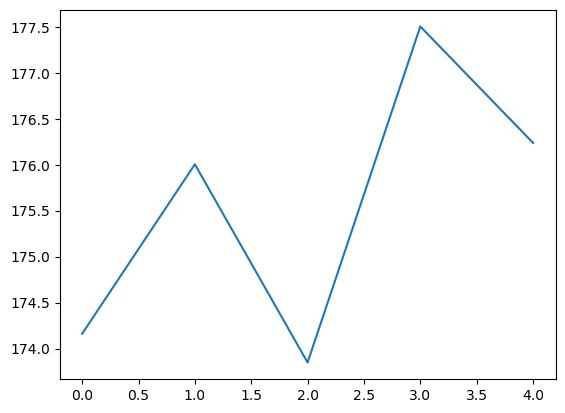

In [158]:
plt.plot(embed_target[3].cpu())

In [159]:
RESET_NOISE_CHARGE = 0
UNCORRELATED_NOISE_CHARGE = 0
e_charge = 1.602e-19
t_sampling = 0.1
DISCRIMINATION_THRESHOLD = 7e3*e_charge

In [160]:
import eagerpy as ep

pixels_signals = ep.astensor(pixels_signals_torch)
time_ticks = ep.astensor(time_ticks_torch)

# List to contain adc values/ticks
full_adc = []
full_adc_ticks_list = []

#Baseline level of noise on integrated charge
q_sum_base = ep.normal(pixels_signals, pixels_signals.shape[0]) * RESET_NOISE_CHARGE * e_charge

# Charge
q = pixels_signals*t_sampling

# Collect cumulative charge over all time ticks + add baseline noise
q_cumsum = q.cumsum(axis=1)
q_sum = q_sum_base[:, ep.newaxis] + q_cumsum

In [161]:
import matplotlib.pyplot as plt

In [162]:
idx_pix, idx_t = torch.where((q_sum.raw[:, 1:] >= DISCRIMINATION_THRESHOLD) & 
            (q_sum.raw[:, :-1] <= DISCRIMINATION_THRESHOLD))

idx_pix = ep.astensor(idx_pix)
idx_t = ep.astensor(idx_t)

# Then linearly interpolate for the intersection point.
m = (q_sum[idx_pix, idx_t+1]-q_sum[idx_pix, (idx_t)])
b = q_sum[idx_pix, idx_t]-m*idx_t
idx_val = (DISCRIMINATION_THRESHOLD - b)/m

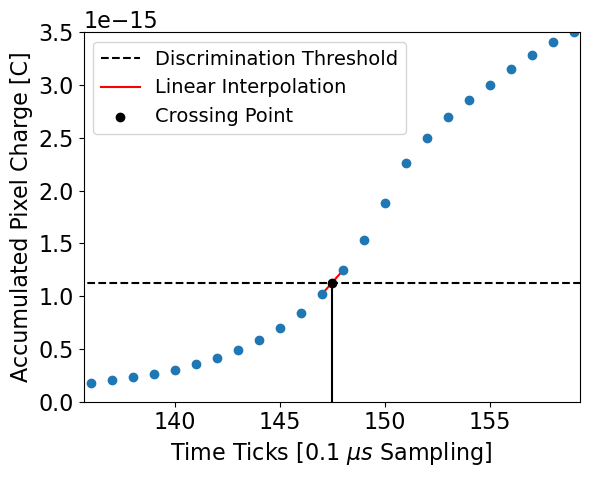

In [176]:
i=1
xvals = torch.linspace(idx_t[i].raw, idx_t[i].raw+1, 100)
interp_vals = m[i].raw*xvals+b[i].raw

plt.scatter(torch.arange(q_sum.shape[1]), q_sum[idx_pix[i]].raw)
plt.plot([0, 1000], [DISCRIMINATION_THRESHOLD]*2, c='k', ls='dashed', label='Discrimination Threshold')
plt.plot([idx_val[i].raw]*2, [0, DISCRIMINATION_THRESHOLD], c='k')
plt.plot(xvals, interp_vals, c='r', label='Linear Interpolation', zorder=0)
plt.scatter(idx_val[i].raw, DISCRIMINATION_THRESHOLD, c='k', label='Crossing Point', zorder=1)
plt.xlim(idx_val[i].raw*0.92, idx_val[i].raw*1.08)
plt.ylim(0, 3.5e-15)
plt.xlabel('Time Ticks [0.1 $\mu s$ Sampling]', fontsize=16)
plt.ylabel('Accumulated Pixel Charge [C]', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.gca().yaxis.get_offset_text().set_fontsize(16)
plt.savefig('figure3.pdf', bbox_inches='tight')
plt.show()

In [5]:
import torch
from glob import glob
import os
import sys
sys.path.insert(0, "../")
from optimize.ranges import ranges
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
import numpy as np
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [8]:
target_file_dir = "../../larnd-sim/nominal_vals_batch/"
shift_1_perc = []
for file in os.listdir(target_file_dir):
    full_path_target = os.path.join(target_file_dir, file)

    target = torch.load(full_path_target).cpu().numpy()[-1]
    
    target_up_1 = target*1.01
    target_down_1 = target*0.99

    dtw_val_up = dtw(target_up_1, target)[-1][-1]
    dtw_val_down = dtw(target_down_1, target)[-1][-1]
    shift_1_perc.append((dtw_val_up+dtw_val_down)/2)
    #check.append(dtw_val)

In [35]:
import pickle
import numpy as np
all_dist = pickle.load(open("../../larnd-sim/examples/collect_dtw_all_params_with_noise.pkl", "rb"))

In [36]:
legend_labels = {
    'Ab' : "$A_{B}$",
    'kb' : "$k_{B}$",
    'eField' : "$\\epsilon$",
    'lifetime' : "$\\tau$",
    'long_diff' : "$D_{L}$",
    'tran_diff' : "$D_{T}$"
}

param_list = ['Ab', 'kb', 'lifetime', 'long_diff', 'tran_diff', 'eField']

In [37]:
import matplotlib.pyplot as plt

In [38]:
all_noisy_things_med = [np.median(np.asarray(all_dist["noise"][i])/np.asarray(shift_1_perc))
                        for i in all_dist['noise'].keys()]
all_noisy_things_perc25 = [np.percentile(np.asarray(all_dist["noise"][i])/np.asarray(shift_1_perc), 25)
                        for i in all_dist['noise'].keys()]
all_noisy_things_perc75 = [np.percentile(np.asarray(all_dist["noise"][i])/np.asarray(shift_1_perc), 75)
                           for i in all_dist['noise'].keys()]
median_noise = np.mean(all_noisy_things_med)
down_noise = np.mean(all_noisy_things_perc25)
up_noise = np.mean(all_noisy_things_perc75)

In [39]:
median_noise, down_noise, up_noise

(1.0437314585914144, 0.8834148105442136, 1.2609292298323356)

In [40]:
noisy_target = {}
for param in param_list:
    all_x_vals = []
    all_y_vals = []
    all_perc_25_vals = []
    all_perc_75_vals = []
    
    noisy_target[param] = {}
    for sample in range(10):
        test = pickle.load(open(f"../../larnd-sim/collect_adc_dtw_{param}_vs_noisy_target_sample{sample}.pkl", "rb"))
        x_vals = (np.asarray(list(test[param].keys()))/ranges[param]['nom']-1)*100
        key_vals = list(test[param].keys())
        y_vals = [np.median(np.asarray(test[param][val])/np.asarray(shift_1_perc)) for val in key_vals]
        perc25_vals = [np.percentile(np.asarray(test[param][val])/np.asarray(shift_1_perc), 25) for val in key_vals]
        perc75_vals = [np.percentile(np.asarray(test[param][val])/np.asarray(shift_1_perc), 75) for val in key_vals]
        
        all_x_vals.append(x_vals)
        all_y_vals.append(y_vals)
        all_perc_25_vals.append(perc25_vals)
        all_perc_75_vals.append(perc75_vals)
        
    noisy_target[param]['x_vals'] = np.mean(all_x_vals, axis=0)
    noisy_target[param]['y_vals'] = np.mean(all_y_vals, axis=0)
    noisy_target[param]['perc_25_vals'] = np.mean(all_perc_25_vals, axis=0)
    noisy_target[param]['perc_75_vals'] = np.mean(all_perc_75_vals, axis=0)

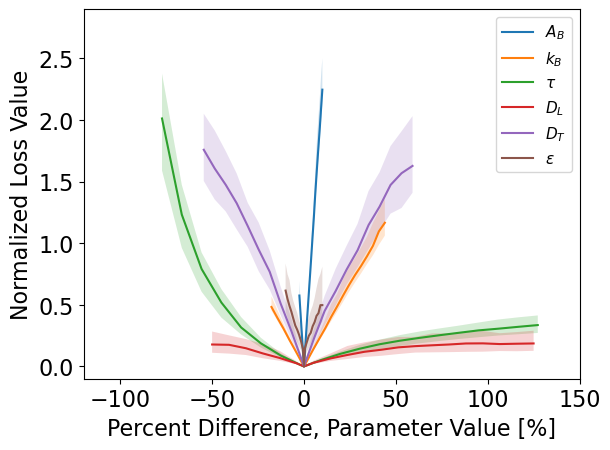

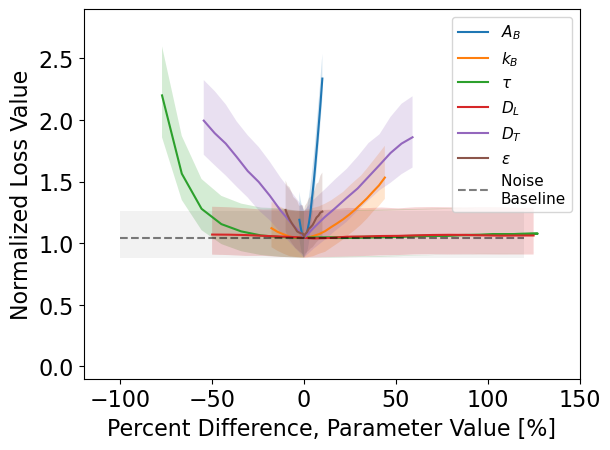

In [47]:
for i, param in enumerate(all_dist.keys()):
    if param == "noise":
        continue
        
    idxs = np.argsort(np.asarray(list(all_dist[param].keys())))
    x_vals = np.asarray(list(all_dist[param].keys()))[idxs]
    y_vals = np.asarray([np.median(np.asarray(all_dist[param][val])/np.asarray(shift_1_perc)) for val in x_vals])
    y_vals_down = np.asarray([np.percentile(np.asarray(all_dist[param][val])/np.asarray(shift_1_perc), 25) for val in x_vals])
    y_vals_up = np.asarray([np.percentile(np.asarray(all_dist[param][val])/np.asarray(shift_1_perc), 75) for val in x_vals])
    idx = np.searchsorted(x_vals,ranges[param]['nom'])
    
    xvals_new = np.insert(x_vals, idx, ranges[param]['nom'])
    yvals_new = np.insert(y_vals, idx, 0)
    yvals_down_new = np.insert(y_vals_down, idx, 0)
    yvals_up_new = np.insert(y_vals_up, idx, 0)
    
    plt.plot((xvals_new/ranges[param]['nom']-1)*100,
              yvals_new, label=legend_labels[param])
    
    plt.fill_between((xvals_new/ranges[param]['nom']-1)*100,
                      yvals_down_new, yvals_up_new, facecolor=f'C{i}', alpha=0.2)
    

plt.xlim(-120, 150)
plt.ylim(-0.1, 2.9)

plt.xlabel("Percent Difference, Parameter Value [%]", fontsize=16)
plt.ylabel("Normalized Loss Value", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=11, loc='upper right')
plt.savefig('figure12a.pdf', bbox_inches='tight')
plt.show()

for i, param in enumerate(all_dist.keys()):
    if param == "noise":
        plt.plot([-100, 120], [median_noise]*2, c='k', ls='dashed', label="Noise \nBaseline", alpha=0.5)
        plt.fill_between([-100, 120], [down_noise]*2, [up_noise]*2, facecolor='k', alpha=0.05)
        continue
        
    idx = np.searchsorted(noisy_target[param]['x_vals'], ranges[param]['nom'])
    
    noisy_target[param]['x_vals_new'] = np.insert(noisy_target[param]['x_vals'], idx, 0)
    noisy_target[param]['y_vals_new'] = np.insert(noisy_target[param]['y_vals'], idx, median_noise)
    noisy_target[param]['perc_25_vals_new'] = np.insert(noisy_target[param]['perc_25_vals'], idx, down_noise)
    noisy_target[param]['perc_75_vals_new'] = np.insert(noisy_target[param]['perc_75_vals'], idx, up_noise)

    plt.plot(noisy_target[param]['x_vals_new'], noisy_target[param]['y_vals_new'], c=f'C{i}',
               label=legend_labels[param])
    plt.fill_between(noisy_target[param]['x_vals_new'], noisy_target[param]['perc_25_vals_new'], noisy_target[param]['perc_75_vals_new'],
                      facecolor=f'C{i}', alpha=0.2)
    
plt.xlim(-120, 150)
plt.ylim(-0.1, 2.9)

plt.xlabel("Percent Difference, Parameter Value [%]", fontsize=16)
plt.ylabel("Normalized Loss Value", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=11, loc='upper right')
plt.savefig('figure12b.pdf', bbox_inches='tight')
    
plt.show()